In [25]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [26]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Generate some SM samples

In [27]:
SMsamples = 50000

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [28]:
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

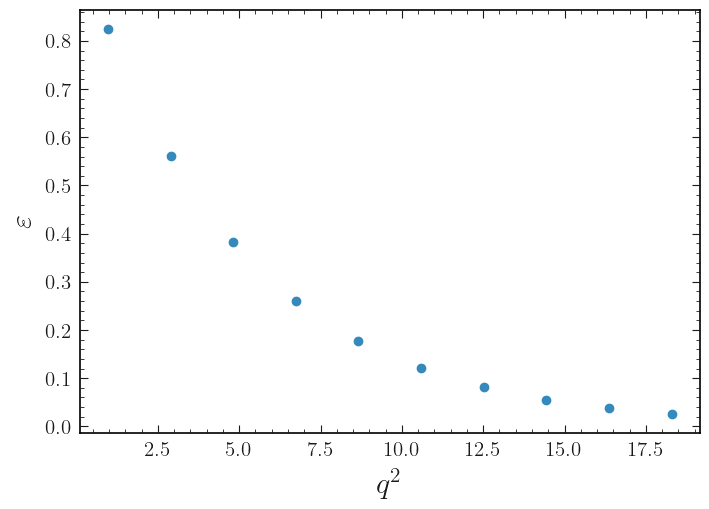

In [29]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

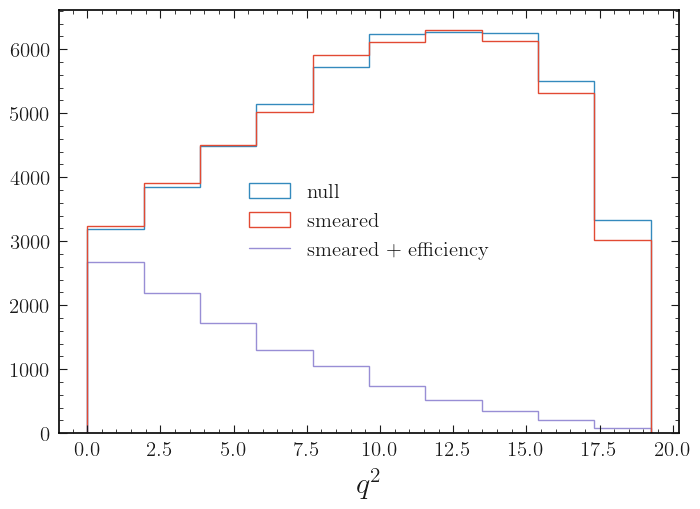

In [30]:
plt.hist(null_samples, binning, histtype='step', label='null')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields *= efficiency(bin_cents)
plt.stairs(null_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [31]:
p['sbnunu::Re{cVL}'].set(5.0)
p['sbnunu::Re{cVR}'].set(0.5)
p['sbnunu::Re{cSL}'].set(0.5)
p['sbnunu::Re{cSR}'].set(0.5)
p['sbnunu::Re{cTL}'].set(0.5)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1234))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [32]:
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

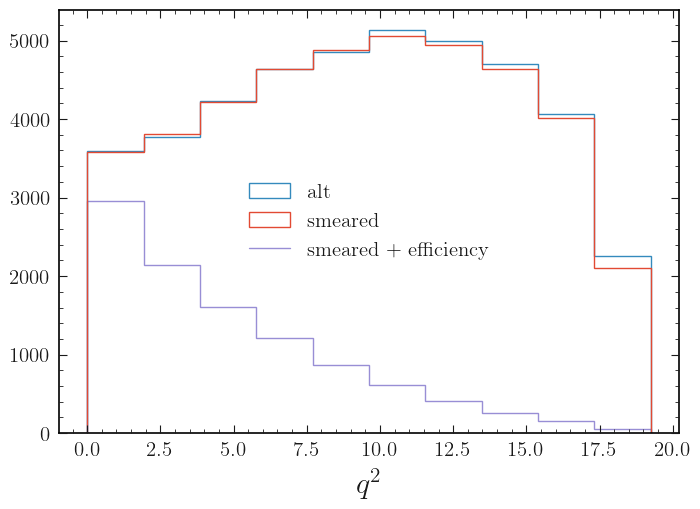

In [33]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields *= efficiency(bin_cents)
plt.stairs(alt_yields, binning, label='smeared + efficiency')
plt.xlabel(r'$q^2$')
plt.legend()

## Set up the mapping distribution

In [34]:
mapping_dist = np.histogramdd([null_samples.flatten(), null_samples_smeared.flatten()], bins=[binning, q2binning])[0]
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [35]:
null = null_pred()
alt = alt_pred()

In [36]:
ana  = analysis()
cvl  = ana.parameters['sbnunu::Re{cVL}'         ].evaluate()
cvr  = ana.parameters['sbnunu::Re{cVR}'         ].evaluate()
csl  = ana.parameters['sbnunu::Re{cSL}'         ].evaluate()
csr  = ana.parameters['sbnunu::Re{cSR}'         ].evaluate()
ctl  = ana.parameters['sbnunu::Re{cTL}'         ].evaluate()
v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()

In [37]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7
0,0.001559,-0.018608,-0.194873,-0.000530,0.012810,0.125146,-0.002349,-0.016020
1,-0.018608,0.280398,2.438509,0.009355,-0.175489,-1.890333,0.155213,1.087167
2,-0.194873,2.438509,27.700878,0.067433,-1.695429,-15.851261,-0.385649,-2.674076
3,-0.000530,0.009355,0.067433,0.000595,-0.007822,-0.096520,0.015261,0.107694
4,0.012810,-0.175489,-1.695429,-0.007822,0.153694,1.596210,-0.116271,-0.825232
5,0.125146,-1.890333,-15.851261,-0.096520,1.596210,18.077389,-2.147100,-15.108303
6,-0.002349,0.155213,-0.385649,0.015261,-0.116271,-2.147100,0.870506,6.106446
7,-0.016020,1.087167,-2.674076,0.107694,-0.825232,-15.108303,6.106446,43.035154


In [38]:
new_params = {
                'cvl'   :{'inits': (6.0,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.0,), 'bounds': ((0., 5. ),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a10, a11, a12, a121, a122), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

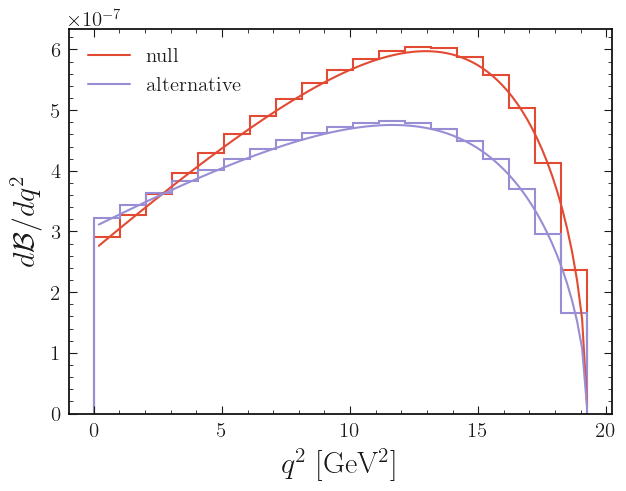

In [39]:
cvl = 5.0
cvr = 0.5
csl = 0.5
csr = 0.5
ctl = 0.5

pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a10, a11, a12, a121, a122)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

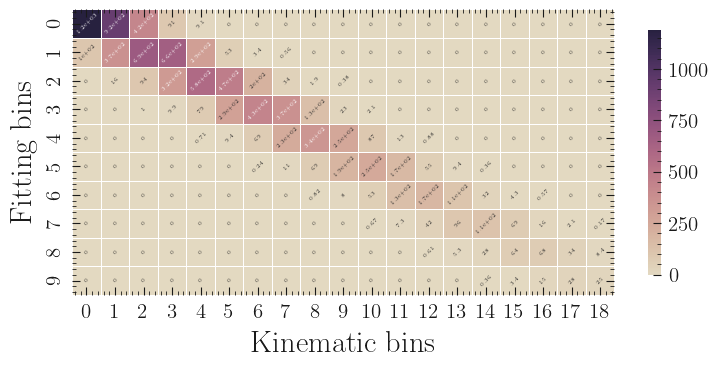

In [40]:
plot.map(cmod)

## Set up the model

In [41]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [2669.3580137068607,
      2190.1920678576935,
      1718.3338850184662,
      1305.9430897967097,
      1046.3726495267877,
      735.9510195934586,
      516.0899074320687,
      341.3120929783789,
      201.42395718270853,
      77.95830580676056],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [51.6658302334034,
        46.799487901660775,
        41.45279104015152,
        36.13783460304048,
        32.347683835582224,
        27.12841719661246,
        22.717612274006015,
        18.474633771157112,
        14.192390819826958,
        8.829400081928588]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [42]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [43]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
# fixed[model.config.par_map['csr']['slice']] = [True]

# pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
# best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.355309
W MnPosDef Matrix forced pos-def by adding to diagonal 0.0277539
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00909055
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00893904


{'cvl': array([4.68821961, 0.41705713]),
 'cvr': array([0.21116741, 0.50462712]),
 'csl': array([3.17553962, 2.01241143]),
 'csr': array([2.45981873, 2.02761945]),
 'ctl': array([0.51607244, 0.03568976]),
 'FFKs_decorrelated[0]': array([0.08918946, 0.87441739]),
 'FFKs_decorrelated[1]': array([-0.03631115,  0.94853488]),
 'FFKs_decorrelated[2]': array([0.01170252, 0.96138962]),
 'FFKs_decorrelated[3]': array([-0.02001527,  0.97392528]),
 'FFKs_decorrelated[4]': array([0.00789884, 0.95951439]),
 'FFKs_decorrelated[5]': array([-0.00441675,  0.98642946]),
 'FFKs_decorrelated[6]': array([0.00460043, 0.98439917]),
 'FFKs_decorrelated[7]': array([0.00263203, 0.98326581]),
 'mu': array([1., 0.]),
 'stat': [[1.0079894038931732, 0.01752179792070052],
  [0.9835799805495437, 0.016871502140168415],
  [0.998862753600692, 0.018758741189013828],
  [1.0199561223969125, 0.02190650176359199],
  [0.9843128317753154, 0.02454450103146738],
  [1.0067553150097486, 0.029450937627885976],
  [0.9965900532322353

In [44]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.688219609196873,
 'cvr': 0.21116740809222787,
 'csl': 3.175539616024162,
 'csr': 2.4598187325660277,
 'ctl': 0.5160724417498306,
 'FFKs[0]': 0.3581302518225723,
 'FFKs[1]': -1.0315036761613228,
 'FFKs[2]': 2.996090772241689,
 'FFKs[3]': 0.28896875777160014,
 'FFKs[4]': 0.4235843743758289,
 'FFKs[5]': 0.7943869741936311,
 'FFKs[6]': 0.5777393527526685,
 'FFKs[7]': 0.9474552092320407,
 'mu': 1.0,
 'stat': [1.0079894038931732,
  0.9835799805495437,
  0.998862753600692,
  1.0199561223969125,
  0.9843128317753154,
  1.0067553150097486,
  0.9965900532322353,
  0.9979087113049135,
  1.0135395387419768,
  0.9765403188815611]}

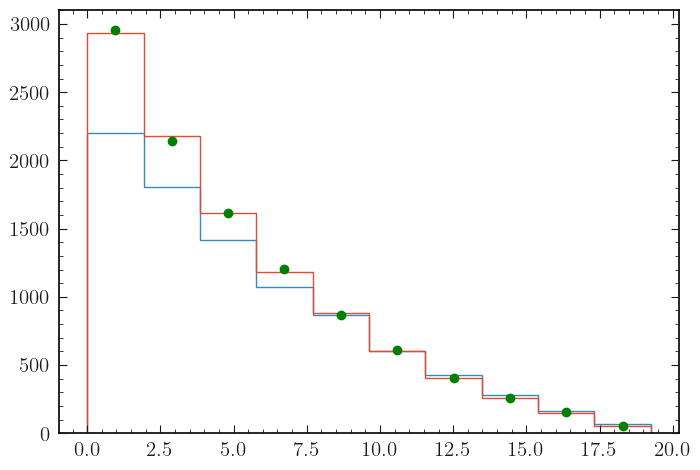

In [45]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')